In [40]:
import Environment
import Shop
from mab.ts_learner import *
from mab.ucb_learner import *
from utilities import *

In this setting we have three shops:
1. **Clairvoyant**: which just naively tests all permutations of possible prices and picks the best one
2. **TS**: which learns the best possible price using Thompson Sampling.
3. **UCB**: which learns the best possible price using Upper Confidence Bound.

The shops are assumed to know everything except for the price of the first item.

In [41]:
shop_ts = Shop.Shop()
shop_ucb = Shop.Shop()
shop_clairvoyant = Shop.Shop()

print(shop_ts.prices1)
print(shop_ts.prices2)

env = Environment.Environment(shop_clairvoyant.prices1,shop_clairvoyant.prices2,shop_clairvoyant.discounts)

# The environment decides the conversion rates, which are shared among all the shops.
shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)
shop_ts.set_conv_rate(None ,env.true_conv2)
shop_ucb.set_conv_rate(None, env.true_conv2)

#Initialize learners
n_arms = len(env.prices1)
shop_ts.set_price_learner('TS', n_arms)
shop_ucb.set_price_learner('UCB', n_arms)


[ 80. 120. 160. 200. 240.]
[100. 150. 200. 250. 300.]


In [42]:
# we have fixed promo fractions
promo_fractions = np.array([[0.3, 0.2, 0.25, 0.25],     # every row is a customer class
                            [0.2, 0.25, 0.30, 0.25],     # every column is a promo type   
                            [0.1, 0.2, 0.3, 0.4],
                            [0.15, 0.15, 0.45, 0.25]])

# we have a fixed price for item 2
price2_index = 2
price2 = env.prices2[price2_index]
max_ind_reward = price2 + max(env.prices1)

In [43]:
#### get clairvoyant price
expected_rewards = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
customers_mean = np.array([25, 25, 25, 25])

for i in range(len(env.prices1)):
    for j in range(env.n_classes):
        expected_reward_from_class = customers_mean[j]*env.prices1[i]*env.true_conv1[j, i]
        for k in range(len(env.discounts)):
            expected_reward_from_class += promo_fractions[j,k]*customers_mean[j]*env.true_conv1[j, i]*price2*env.true_conv2[k, j, price2_index]*(1 - env.discounts[k])
        expected_rewards[i] += expected_reward_from_class


print(env.prices1)
print(expected_rewards)

clairvoyant_price_index = np.argmax(expected_rewards)
clairvoyant_price = env.prices1[clairvoyant_price_index]

[ 80. 120. 160. 200. 240.]
[13007.77348363  7749.6227977  13115.96804135 16979.33391655
 17798.45996105]


In [44]:
print(max_ind_reward)
print(clairvoyant_price)

440.0
240.0


In [45]:
days = 365

ts_rewards_per_class_per_day = []
u_rewards_per_class_per_day = []
clairvoyant_per_class_per_day = []

for day in range(days):
    #Generating customers for the next day
    env.generate_next_day_customers()
    
    #Every shop knows how many customers are coming
    shop_clairvoyant.set_expected_customers(env.customers)
    shop_ts.set_expected_customers(env.customers)
    shop_ucb.set_expected_customers(env.customers)

    #Pull arm from learners 

    chosen_price_ts = shop_ts.price_learner.pull_arm()
    #chosen_price_ts = shop_ts.price_learner.pull_arm()
    chosen_price_ucb = shop_ucb.price_learner.pull_arm() 


    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)
    


    clairvoyant_per_class = []
    revenue_ts = []
    revenue_ucb = []
    revenue_c = []


    for cust in customers:
        partial_revenue = 0
        cust = int(cust)
        #Check if first item has been bought and update the parameters
        selected_promo = 0
        #if len(promos[cust]) > 0:
        selected_promo = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions[cust])

        cr1 = shop_clairvoyant.conv1[cust, clairvoyant_price_index]
        cr2 = shop_clairvoyant.conv2[selected_promo, cust, price2_index]
        c_ind_reward = clairvoyant_price*cr1 + price2*cr1*cr2*(1-shop_clairvoyant.discounts[selected_promo])   

        ts_has_bought1 = env.round1(cust, env.prices1[chosen_price_ts])
        ucb_has_bought1 = env.round1(cust, env.prices1[chosen_price_ucb])
        #c_has_bought1 = env.round1(cust, clairvoyant_price)

        partial_revenue_ts = ts_has_bought1*shop_ts.prices1[chosen_price_ts]
        partial_revenue_ucb = ucb_has_bought1*shop_ucb.prices1[chosen_price_ucb]
        # partial_revenue_c = c_has_bought1*clairvoyant_price

        #Check if second item has been bought
        if ts_has_bought1 == 1:
            partial_revenue_ts += price2*shop_ts.conv2[selected_promo, cust, price2_index]*(1-shop_ts.discounts[selected_promo])
        revenue_ts.append(partial_revenue_ts)

        norm_ts = partial_revenue_ts / max_ind_reward
        shop_ts.price_learner.update(chosen_price_ts, norm_ts)
        
        if ucb_has_bought1 == 1:
            partial_revenue_ucb += price2*shop_ucb.conv2[selected_promo, cust, price2_index]*(1-shop_ucb.discounts[selected_promo])
        revenue_ucb.append(partial_revenue_ucb)

        norm_ucb = partial_revenue_ucb / max_ind_reward
        shop_ucb.price_learner.update(chosen_price_ucb, norm_ucb)

        # if c_has_bought1 == 1:
        #     partial_revenue_c += price2*shop_clairvoyant.conv2[selected_promo, cust, price2_index]*(1-shop_clairvoyant.discounts[selected_promo])
        revenue_c.append(c_ind_reward)
        #expected_revenue = shop_clairvoyant.best_price[0]*env.true_conv1[cust, index(env.prices1, shop_clairvoyant.best_price[0])] + env.true_conv1[cust, index(env.prices1, shop_clairvoyant.best_price[0])]*env.true_conv2[shop_clairvoyant.matched_promos[cust], cust, index(env.prices2, shop_clairvoyant.best_price[1])]*shop_clairvoyant.best_price[1]*(1-shop_clairvoyant.discounts[shop_clairvoyant.matched_promos[cust]])
        #clairvoyant_per_class.append(expected_revenue)
    
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    clairvoyant_per_class_per_day.append(np.mean(revenue_c))


C:\Users\alice\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [46]:
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(clairvoyant_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

1771.4569294291286
2948.8885058411834


Text(0, 0.5, 'Revenue')

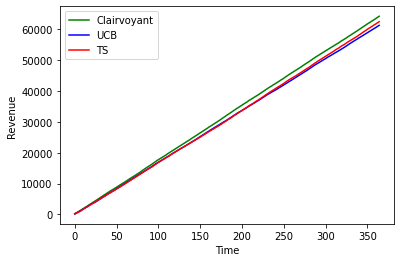

In [47]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(clairvoyant_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(u_rewards_per_class_per_day),color='blue',label='UCB')
plt.plot(np.cumsum(ts_rewards_per_class_per_day),color='red',label = 'TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

#plt.yscale('symlog')


Text(0, 0.5, 'Regret')

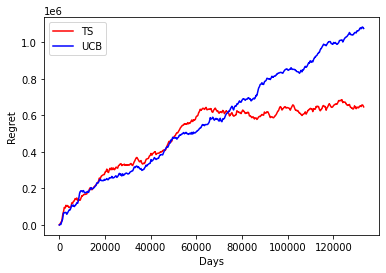

In [48]:
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(clairvoyant_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')